In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
import joblib
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
# Load the original dataset
ORIGINAL_DATASET_PATH = '../data/raw/train.csv'
data = pd.read_csv(ORIGINAL_DATASET_PATH)

# Separate features and target variable
X = data.drop(columns=['loan_status'])
y = data['loan_status']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [3]:

# Split the data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing steps to the dataset
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


In [4]:
# Fit and transform the training data
X_train_processed = pipeline.fit_transform(X_train)
X_validation_processed = pipeline.transform(X_validation)

In [5]:
# Define the XGBoost model with L2 and L1 regularization
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    reg_alpha=1.0,  # L1 regularization term
    reg_lambda=10.0,  # L2 regularization term
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [6]:
# Train the XGBoost model with progress bar
print("Training the XGBoost model with L2 and L1 regularization...")
for _ in tqdm(range(1), desc='Training XGBoost Model'):
    xgb_model.fit(X_train_processed, y_train, eval_set=[(X_validation_processed, y_validation)], early_stopping_rounds=50, verbose=False)


Training the XGBoost model with L2 and L1 regularization...


Training XGBoost Model:   0%|                                                                              | 0/1 [00:00<?, ?it/s]C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
Training XGBoost Model: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.36s/it]


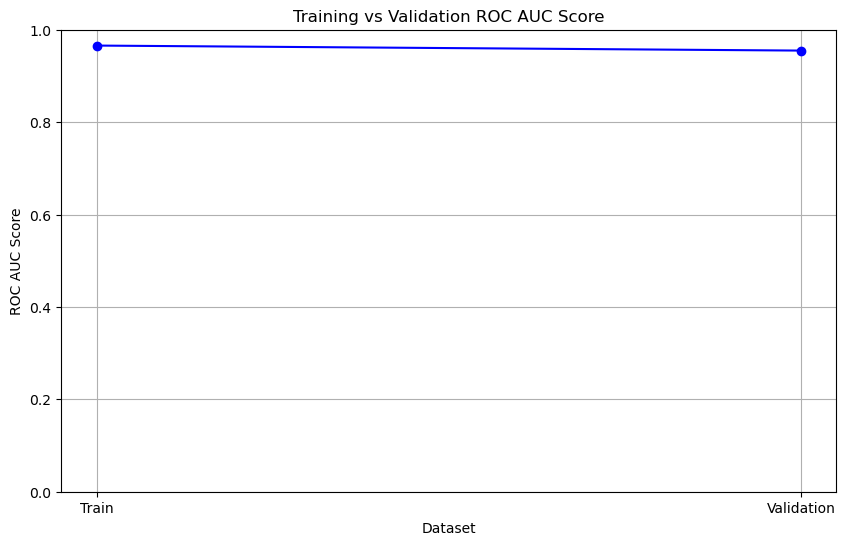

XGBoost Model with L2 and L1 Regularization - ROC AUC Score (Validation): 0.9548348068515246
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.92      0.73      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



In [7]:

# Make predictions on the training set and validation set
y_train_pred_proba = xgb_model.predict_proba(X_train_processed)[:, 1]
y_validation_pred_proba = xgb_model.predict_proba(X_validation_processed)[:, 1]

# Calculate ROC AUC for training and validation sets
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
validation_roc_auc = roc_auc_score(y_validation, y_validation_pred_proba)

# Plot the ROC AUC scores to determine overfitting or underfitting
plt.figure(figsize=(10, 6))
plt.plot(['Train', 'Validation'], [train_roc_auc, validation_roc_auc], marker='o', linestyle='-', color='b')
plt.title('Training vs Validation ROC AUC Score')
plt.xlabel('Dataset')
plt.ylabel('ROC AUC Score')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

# Evaluate the model on the validation set
y_pred = xgb_model.predict(X_validation_processed)
print(f"XGBoost Model with L2 and L1 Regularization - ROC AUC Score (Validation): {validation_roc_auc}")
print(classification_report(y_validation, y_pred))


In [8]:

# Save the trained XGBoost model
XGB_MODEL_PATH = '../models/xgb_model.pkl'
joblib.dump(xgb_model, XGB_MODEL_PATH)
print(f"XGBoost model saved to {XGB_MODEL_PATH}")


XGBoost model saved to ../models/xgb_model.pkl


In [ ]:

# Load the test dataset
TEST_SET_PATH = '../data/raw/test.csv'
X_test = pd.read_csv(TEST_SET_PATH)

# Apply preprocessing to the test dataset
X_test_processed = pipeline.transform(X_test)

# Make predictions on the test set
y_test_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

# Create a DataFrame for submission
submission = pd.DataFrame({'id': X_test['id'], 'loan_status': y_test_pred_proba})

# Save the submission to a CSV file
SUBMISSION_PATH = '../data/processed/submission.csv'
submission.to_csv(SUBMISSION_PATH, index=False)

print(f"Submission file saved to {SUBMISSION_PATH}")

In [ ]:
# Define the new model with reduced complexity and regularization
model = RidgeClassifier(alpha=1.0, random_state=42)

# Train the model with progress bar
print("Training the model with reduced complexity and regularization...")
for _ in tqdm(range(1), desc='Training Model'):
    model.fit(X_train_processed, y_train)


In [ ]:

# Make predictions on the training set and validation set
y_train_pred_proba = model.decision_function(X_train_processed)
y_validation_pred_proba = model.decision_function(X_validation_processed)

# Calculate ROC AUC for training and validation sets
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
validation_roc_auc = roc_auc_score(y_validation, y_validation_pred_proba)

# Plot the ROC AUC scores to determine overfitting or underfitting
plt.figure(figsize=(10, 6))
plt.plot(['Train', 'Validation'], [train_roc_auc, validation_roc_auc], marker='o', linestyle='-', color='b')
plt.title('Training vs Validation ROC AUC Score')
plt.xlabel('Dataset')
plt.ylabel('ROC AUC Score')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

# Evaluate the model on the validation set
y_pred = model.predict(X_validation_processed)
print(f"Model with Reduced Complexity - ROC AUC Score (Validation): {validation_roc_auc}")
print(classification_report(y_validation, y_pred))


In [ ]:

# Save the trained model
MODEL_PATH = '../models/ridge_model.pkl'
joblib.dump(model, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


In [ ]:

# Load the test dataset
TEST_SET_PATH = '../data/raw/test.csv'
X_test = pd.read_csv(TEST_SET_PATH)

# Apply preprocessing to the test dataset
X_test_processed = pipeline.transform(X_test)

# Make predictions on the test set
y_test_pred_proba = model.decision_function(X_test_processed)

# Create a DataFrame for submission
submission = pd.DataFrame({'id': X_test['id'], 'loan_status': y_test_pred_proba})

# Save the submission to a CSV file
SUBMISSION_PATH = '../data/processed/submission.csv'
submission.to_csv(SUBMISSION_PATH, index=False)

print(f"Submission file saved to {SUBMISSION_PATH}")

In [ ]:

# Define base models for stacking
base_models = [
    ('xgboost', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('catboost', CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)


In [ ]:

# Create the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)


In [ ]:

# Train the stacking model with progress bar
print("Training the stacking model...")
for _ in tqdm(range(10), desc='Training Stacking Model'):
    stacking_model.fit(X_train_processed, y_train)


In [ ]:
# Make predictions on the training set and validation set
y_train_pred_proba = stacking_model.predict_proba(X_train_processed)[:, 1]
y_validation_pred_proba = stacking_model.predict_proba(X_validation_processed)[:, 1]

# Calculate ROC AUC for training and validation sets
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
validation_roc_auc = roc_auc_score(y_validation, y_validation_pred_proba)

# Plot the ROC AUC scores to determine overfitting or underfitting
plt.figure(figsize=(10, 6))
plt.plot(['Train', 'Validation'], [train_roc_auc, validation_roc_auc], marker='o', linestyle='-', color='b')
plt.title('Training vs Validation ROC AUC Score')
plt.xlabel('Dataset')
plt.ylabel('ROC AUC Score')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

In [ ]:

# Make predictions on the validation set
y_pred = stacking_model.predict(X_validation_processed)
y_pred_proba = stacking_model.predict_proba(X_validation_processed)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_validation, y_pred_proba)
print(f"Stacking Model - ROC AUC Score: {roc_auc}")
print(classification_report(y_validation, y_pred))


In [ ]:

# Save the trained stacking model
STACKING_MODEL_PATH = '../models/stacking_model_all_features.pkl'
joblib.dump(stacking_model, STACKING_MODEL_PATH)
print(f"Stacking model saved to {STACKING_MODEL_PATH}")

## Submission

In [ ]:
# Load the test dataset
TEST_SET_PATH = '../data/raw/test.csv'
X_test = pd.read_csv(TEST_SET_PATH)

# Apply preprocessing to the test dataset
X_test_processed = pipeline.transform(X_test)

# Make predictions on the test set
y_test_pred_proba = stacking_model.predict_proba(X_test_processed)[:, 1]

# Create a DataFrame for submission
submission = pd.DataFrame({'id': X_test['id'], 'loan_status': y_test_pred_proba})

# Save the submission to a CSV file
SUBMISSION_PATH = '../data/processed/submission.csv'
submission.to_csv(SUBMISSION_PATH, index=False)

print(f"Submission file saved to {SUBMISSION_PATH}")